# Classifying Suspicious Firms

#### Citation of Data
Hooda,Nishtha. (2018). Audit Data. UCI Machine Learning Repository. https://doi.org/10.24432/C5930Q.

## Introduction 

Having the need to interact with firms on a daily basis, many people in the world have been victims of fraudulent firms. Although auditors may be able to track a few down, not all can be located. Can we use present and historical risk factors to determine if a firm can be labeled as a fraudulent risk or not?

The data, stored as a CSV file, contains one year (2015-2016) exhaustive information on firms that is collected by the Auditor Office of India. The aim of this project is to use this data to develop a model which will help auditors by classifying and finding fraudulent firms. A variety of risk factors are examined in order to reach a score of either 1 (fraudulent) or 0 (not fraudulent) for a firm. There are missing values in the dataset that will be corrected by tidying the data.


## Exploratory data analysis

First, we load in the packages as well as loading in our data.

In [83]:
set.seed(888)

# Loads in the packages
library(tidyverse)
library(repr)
library(tidymodels)
install.packages("kknn")
library(kknn)

# Loads the data into the variable
url <- "https://raw.githubusercontent.com/alexander-zhong/dsci-100-project/main/data/audit_risk.csv"
raw_audit_risk_data <- read_csv(url) 

head(raw_audit_risk_data)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

New names:
• `Score_B` -> `Score_B...7`
• `Score_B` -> `Score_B...11`
Rows: 776 Columns: 27
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): LOCATION_ID
dbl (26): Sector_score, PARA_A, Score_A, Risk_A, PARA_B, Score_B...7, Risk_B...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Sector_score,LOCATION_ID,PARA_A,Score_A,Risk_A,PARA_B,Score_B...7,Risk_B,TOTAL,numbers,⋯,RiSk_E,History,Prob,Risk_F,Score,Inherent_Risk,CONTROL_RISK,Detection_Risk,Audit_Risk,Risk
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3.89,23,4.18,0.6,2.508,2.50,0.2,0.500,6.68,5,⋯,0.4,0,0.2,0,2.4,8.574,0.4,0.5,1.7148,1
3.89,6,0.00,0.2,0.000,4.83,0.2,0.966,4.83,5,⋯,0.4,0,0.2,0,2.0,2.554,0.4,0.5,0.5108,0
3.89,6,0.51,0.2,0.102,0.23,0.2,0.046,0.74,5,⋯,0.4,0,0.2,0,2.0,1.548,0.4,0.5,0.3096,0
3.89,6,0.00,0.2,0.000,10.80,0.6,6.480,10.80,6,⋯,0.4,0,0.2,0,4.4,17.530,0.4,0.5,3.5060,1
3.89,6,0.00,0.2,0.000,0.08,0.2,0.016,0.08,5,⋯,0.4,0,0.2,0,2.0,1.416,0.4,0.5,0.2832,0
3.89,6,0.00,0.2,0.000,0.83,0.2,0.166,0.83,5,⋯,0.4,0,0.2,0,2.0,2.156,0.4,0.5,0.4312,0


As we can see from the preview, there is a lot of tidying and cleaning of
the data that needs to be done before using it. In addition, from a quick glance of the data, we can recognize that using these variables (inherent risk, detection risk, audit risk, control risk) will be ideal for our classifier since other variables in this dataset do not have a clear definition or meaning/information behind them making it very hard to believe if they are variables to can contribute at all to our classifier. So, lets tidy the data and select the variables we need.

In [60]:
# Clean up and turn the Risk variable into a factor for our classification
audit_risk_data <- raw_audit_risk_data |>
    mutate(Risk = as_factor(Risk)) |>
    mutate(Risk = fct_recode(Risk, "Fraudulent" = "1", "Not Fraudulent" = "0")) |>
    select(Risk, CONTROL_RISK, Inherent_Risk, Audit_Risk) |>
    drop_na()
    

head(audit_risk_data)

Risk,CONTROL_RISK,Inherent_Risk,Audit_Risk
<fct>,<dbl>,<dbl>,<dbl>
Fraudulent,0.4,8.574,1.7148
Not Fraudulent,0.4,2.554,0.5108
Not Fraudulent,0.4,1.548,0.3096
Fraudulent,0.4,17.530,3.5060
Not Fraudulent,0.4,1.416,0.2832
Not Fraudulent,0.4,2.156,0.4312


Lets quickly take a look at our data by representing the data with a few 
tables:

In [61]:
# see the total number of firms that are considered a risk or not a risk
preliminary_table1 <- audit_risk_data |>
    group_by(Risk) |>
    summarize(Count = n())
preliminary_table1


# see the average of our predictor variables
preliminary_table2 <- audit_risk_data |>
    select(CONTROL_RISK, Audit_Risk, Inherent_Risk) |>
    map_df(mean, na.rm = TRUE)

preliminary_table2

Risk,Count
<fct>,<int>
Not Fraudulent,471
Fraudulent,305


CONTROL_RISK,Audit_Risk,Inherent_Risk
<dbl>,<dbl>,<dbl>
0.5726804,7.168158,17.68061


The amount of fraudulent firms is way greater than we expected! Lets take look at the scatter plot distribution of our data with the variables we decided to use. Lets also standardize the data first so we can have a more accurate comparison between the variables.

Warning message:
“Removed 106 rows containing missing values (`geom_point()`).”


CONTROL_RISK,Audit_Risk,Inherent_Risk,Risk
<dbl>,<dbl>,<dbl>,<fct>
-0.3884112,-0.14103211,-0.166360462,Fraudulent
-0.3884112,-0.17216938,-0.276334397,Not Fraudulent
-0.3884112,-0.17737271,-0.294712101,Not Fraudulent
-0.3884112,-0.09470897,-0.002751399,Fraudulent
-0.3884112,-0.17805546,-0.297123490,Not Fraudulent
-0.3884112,-0.17422795,-0.283605099,Not Fraudulent


Warning message:
“Removed 136 rows containing missing values (`geom_point()`).”


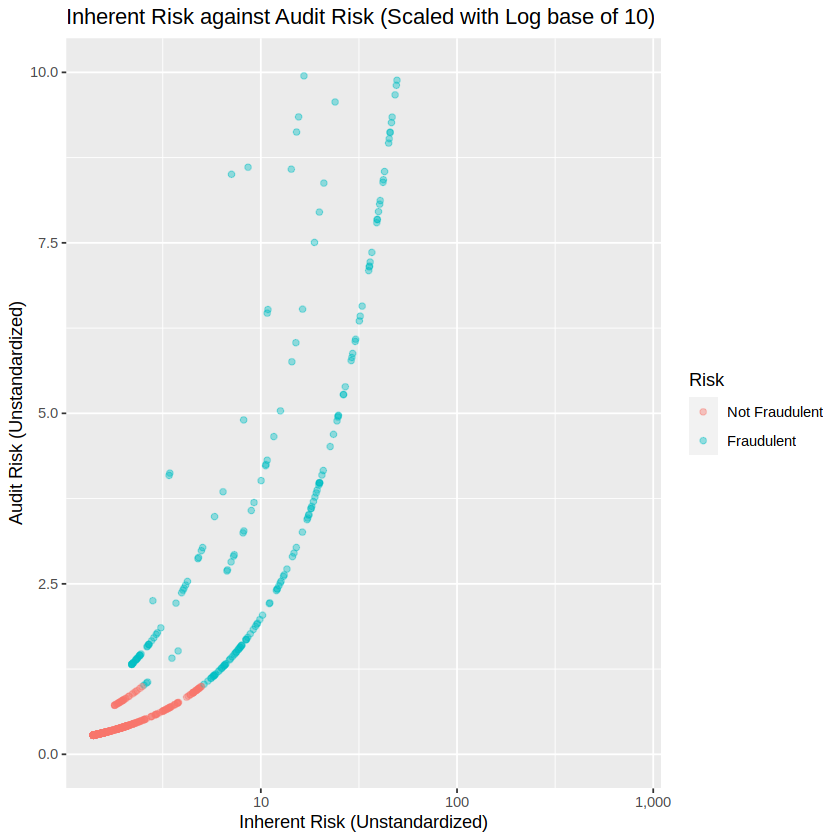

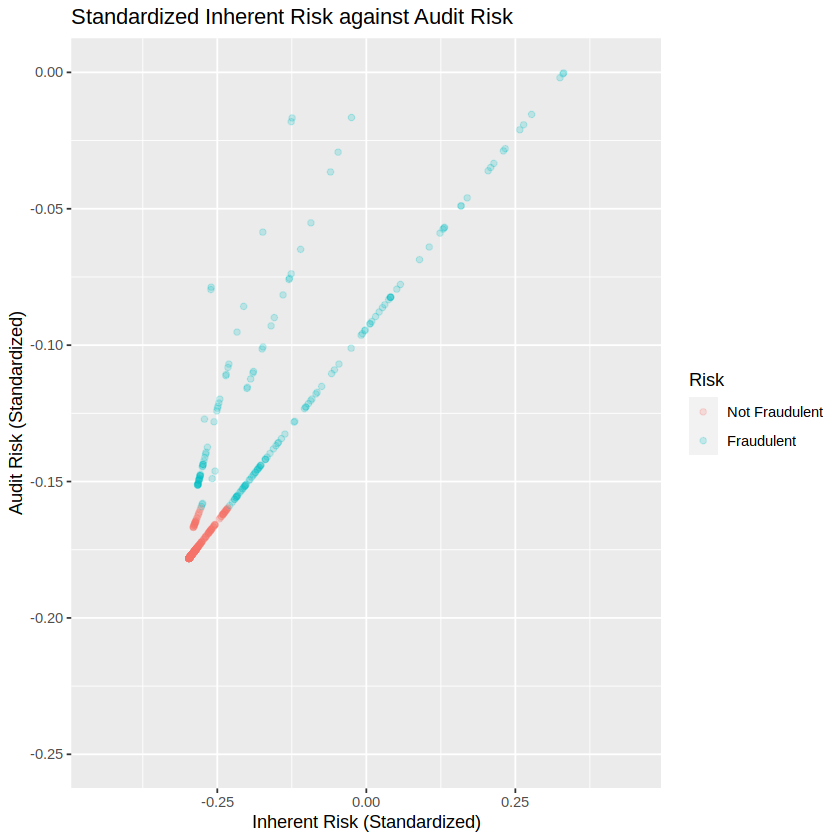

In [62]:
preliminary_plot1 <- audit_risk_data |> 
    ggplot(aes(x = Inherent_Risk, y = Audit_Risk, color = Risk)) +
    geom_point(alpha = 0.4) + 
    labs(x = "Inherent Risk (Unstandardized)", y = "Audit Risk (Unstandardized)") +
    ggtitle("Inherent Risk against Audit Risk") +
    scale_x_log10(labels = label_comma()) +
    ylim(0, 10) +
    ggtitle("Inherent Risk against Audit Risk (Scaled with Log base of 10)")
preliminary_plot1




#### Standardizing the data
audit_recipe <- recipe(Risk ~ CONTROL_RISK + Audit_Risk + Inherent_Risk, data = audit_risk_data) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) |>
    prep()

audit_risk_scaled <- bake(audit_recipe, audit_risk_data)

head(audit_risk_scaled)

preliminary_plot2 <- audit_risk_scaled |> 
    ggplot(aes(x = Inherent_Risk, y = Audit_Risk, color = Risk)) +
    geom_point(alpha = 0.2) + 
    labs(x = "Inherent Risk (Standardized)", y = "Audit Risk (Standardized)") +
    ggtitle("Standardized Inherent Risk against Audit Risk") +
    xlim(-0.45, 0.45) +
    ylim(-0.25, 0)
    
preliminary_plot2

From all our visualization and tables, we can conclude that the three variables (control risk, inherent risk, and audit risk) can be used to train our classifier. As we can see, there is a clear upward trend in the scatter plots of Audit Risk vs Inherent Risk leading to more fraudulent firms which further supports our decision in using these variables.

## Building Classifier

### Tuning

This classifier will be based on the K-Nearest Neighbors algorithm to determine
whether a firm is considered fraudulent or not. In order to do so, tune and evaluate the classifier for the most optimal K value and testing the accuracy.

First, lets scale the data as well as split the data randomly with set.seed(888) in code cells above for a 70% training data and a 30% testing data.

In [65]:
audit_risk_split <- initial_split(audit_risk_data, prop = .7, strata = Risk)
audit_risk_train <- training(audit_risk_split)
audit_risk_test <- testing(audit_risk_split)

audit_recipe <- recipe(Risk ~ CONTROL_RISK + Audit_Risk + Inherent_Risk, data = audit_risk_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

Now, we want to use cross validation within our training data to choose the correct k-value.

In [82]:
audit_vfold <- vfold_cv(audit_risk_train, v = 5, strata = Risk) 


knn_spec <- nearest_neighbor(
    weight_func = "rectangular", 
    neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_results <- workflow() |>
    add_recipe(audit_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = audit_vfold, grid = 10) |>
    collect_metrics()



Warning message:
“Removed 5 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 5 rows containing missing values (`geom_line()`).”


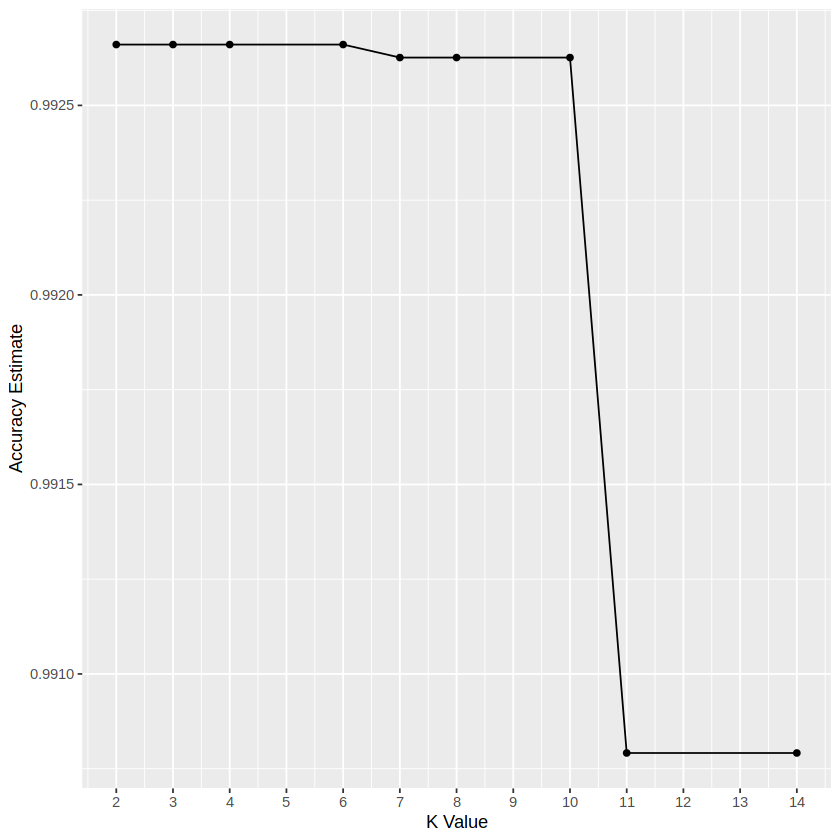

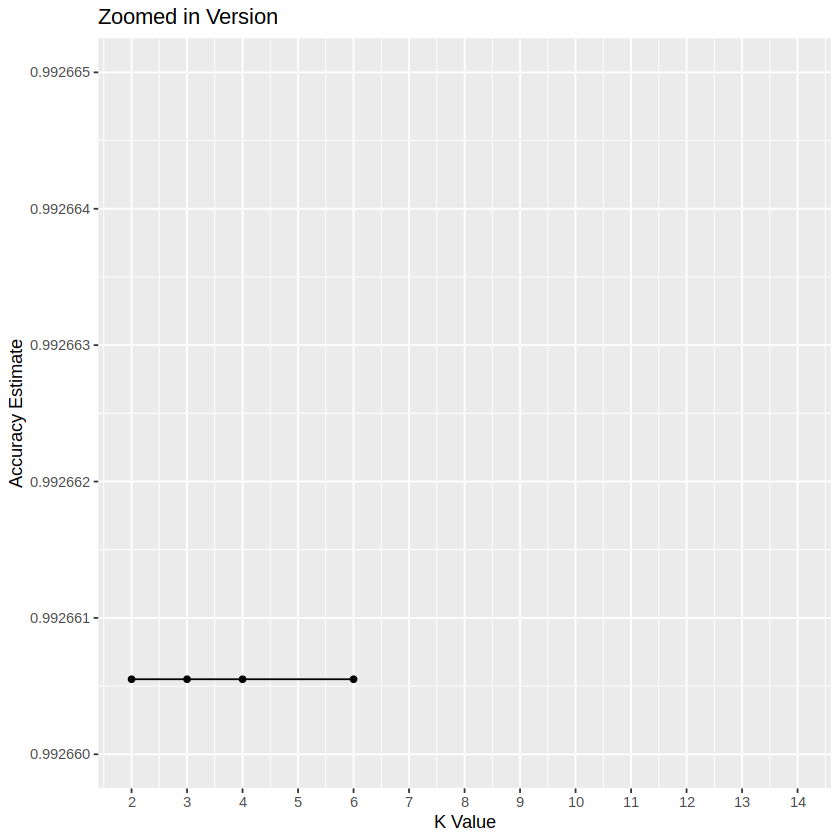

In [105]:
accuracies <- knn_results |> 
       filter(.metric == "accuracy")

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "K Value", y = "Accuracy Estimate") +
    scale_x_continuous(breaks = seq(0, 14, by = 1)) 
accuracy_versus_k

accuracy_versus_k2 <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "K Value", y = "Accuracy Estimate") +
    scale_x_continuous(breaks = seq(0, 14, by = 1)) +
    ylim(0.992660, 0.992665) +
    ggtitle("Zoomed in Version")
accuracy_versus_k2

As we can see from our tuning, any value 2 to 6 would provide a very high accuracy. But, as we increase the k value from 10 to 11, there is a dramatic drop. In our case, we should built our classifier with the k-value of 6 to maximize accuracy.

### Constructing the Classifier with K Value of 6

In [108]:
audit_recipe <- recipe(Risk ~ CONTROL_RISK + Audit_Risk + Inherent_Risk, data = audit_risk_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 6) |>
       set_engine("kknn") |>
       set_mode("classification")


audit_fit <- workflow() |>
    add_recipe(audit_recipe) |>
    add_model(knn_spec) |>
    fit(data = audit_risk_train)

audit_predictions <- predict(audit_fit, audit_risk_test) |>
    bind_cols(audit_risk_test)

head(audit_predictions)

.pred_class,Risk,CONTROL_RISK,Inherent_Risk,Audit_Risk
<fct>,<fct>,<dbl>,<dbl>,<dbl>
Fraudulent,Fraudulent,0.4,8.5740,1.71480
Not Fraudulent,Not Fraudulent,0.4,2.5540,0.51080
Fraudulent,Fraudulent,0.4,17.2060,3.44120
Not Fraudulent,Not Fraudulent,0.4,4.3720,0.87440
Not Fraudulent,Not Fraudulent,0.4,1.5694,0.31388
Fraudulent,Fraudulent,0.4,9.3840,1.87680


Now that we have used our training data to creat our classifier and used it to predict the training data, we can take a look at the metrics to see how well our classifier did!

In [110]:
audit_prediction_metrics <- audit_predictions |>
    metrics(truth = Risk, estimate = .pred_class)


audit_prediction_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9957265
kap,binary,0.9910269


As we can see here, our accuracy of our classifier is pretty high with
0.9957265 success rate when classifying our testing data.

## Discussion
- summarize what you found
- discuss whether this is what you expected to find?
- discuss what impact could such findings have?
- discuss what future questions could this lead to?

## References

...